###  প্রি-ট্রেইনড মডেল VGG16 এর লেয়ার

In [1]:


import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16; VGG16().summary()

553467096/553467096 [==============================] - 223s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

### প্রি-ট্রেইনড মডেল ResNet-50 এর লেয়ার

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50; ResNet50().summary()

102967424/102967424 [==============================] - 45s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [11]:
try:
  # শুধুমাত্র টেন্সর-ফ্লো ২.x ব্যবহার করবো 
  %tensorflow_version 2.0
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import datetime as dt

%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard
log_dir='log/'

split = (80, 10, 10)
#cat_dog_spl = tfds.Split.TRAIN.subsplit(weighted=split)
cat_dog_spl = ['train[:80%]','train[80%:90%]','train[90%:]']

(cat_train, cat_valid, cat_test), info = tfds.load('cats_vs_dogs', split=list(cat_dog_spl), with_info=True, as_supervised=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


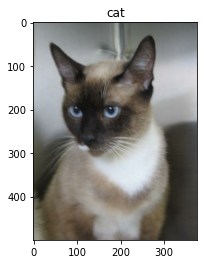

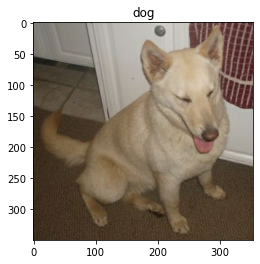

In [12]:
# লেবেল সহ ছবি দেখি
get_label_name = info.features['label'].int2str
for image, label in cat_test.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))
  image_ = image

In [13]:
IMAGE_SIZE = 100
def pre_process_image(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.0
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

TRAIN_BATCH_SIZE = 64
cat_train = cat_train.map(pre_process_image).shuffle(1000).repeat().batch(TRAIN_BATCH_SIZE)
cat_valid = cat_valid.map(pre_process_image).repeat().batch(1000)

In [14]:
head = tf.keras.Sequential()
head.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(32, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(64, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

###  ‘স্ট্যান্ডার্ড ফুললি কানেক্টেড ক্লাসিফায়ার’ 

In [15]:
standard_classifier = tf.keras.Sequential()
standard_classifier.add(layers.Flatten())
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.Dense(1))
standard_classifier.add(layers.Activation('sigmoid'))

In [16]:
standard_classifier_with_do = tf.keras.Sequential()
standard_classifier_with_do.add(layers.Flatten())
standard_classifier_with_do.add(layers.BatchNormalization())
standard_classifier_with_do.add(layers.Dense(100))
standard_classifier_with_do.add(layers.Activation('relu'))
standard_classifier_with_do.add(layers.Dropout(0.5))
standard_classifier_with_do.add(layers.BatchNormalization())
standard_classifier_with_do.add(layers.Dense(100))
standard_classifier_with_do.add(layers.Activation('relu'))
standard_classifier_with_do.add(layers.Dense(1))
standard_classifier_with_do.add(layers.Activation('sigmoid'))

In [17]:
average_pool = tf.keras.Sequential()
average_pool.add(layers.AveragePooling2D())
average_pool.add(layers.Flatten())
average_pool.add(layers.Dense(1, activation='sigmoid'))

###  টেন্সর-ফ্লো ‘কল ব্যাক’

In [18]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))]

###  হেড এবং ব্যাকএড-->গ্লোবাল অ্যাভারেজ পুলিং এর অংশ

In [19]:
pool_model = tf.keras.Sequential([
    head, 
    average_pool
])

In [20]:
pool_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))]

In [ ]:
pool_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=7, 
               validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

Epoch 1/7
363/363 [==============================] - 206s 564ms/step - loss: 0.5242 - accuracy: 0.7357 - val_loss: 0.6371 - val_accuracy: 0.6148
Epoch 2/7
363/363 [==============================] - 204s 561ms/step - loss: 0.4240 - accuracy: 0.8059 - val_loss: 0.9280 - val_accuracy: 0.6091
Epoch 3/7
252/363 [===================>..........] - ETA: 55s - loss: 0.3784 - accuracy: 0.8376

In [ ]:
# standard model

standard_model = tf.keras.Sequential([
    head, 
    standard_classifier
])

standard_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))]

standard_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=10, validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

drop-out dekte hobe